In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Importing relevant packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


# Loading the data

In [3]:
houseprice_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv",
                              index_col=0)
#houseprice_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv",
#                             index_col=0)

# Exploratory Data Analysis
## Checking the shape of the data

In [4]:
print(houseprice_train.shape)
#print(houseprice_test.shape)

(1460, 80)


## Checking out the first few rows

In [5]:
display(houseprice_train.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Dropping duplicates

In [6]:
houseprice_train.drop_duplicates(inplace = True)

## Checking the data types of different variables

In [7]:
houseprice_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [8]:
proportion_of_na =pd.DataFrame(houseprice_train.isna().sum().sort_values(ascending = False)/
                               len(houseprice_train), columns = ['proportions'])
proportion_of_na = proportion_of_na.reset_index()

proportion_of_na

,index,proportions
0,PoolQC,0.995205
1,MiscFeature,0.963014
2,Alley,0.937671
3,Fence,0.807534
4,MasVnrType,0.597260
...,...,...
75,Exterior1st,0.000000
76,RoofMatl,0.000000
77,RoofStyle,0.000000
78,YearRemodAdd,0.000000


## Dropping missing values in columns where the proportion of missing values is less than five percent

In [9]:
columns_to_drop_na = []
for row in range(len(proportion_of_na)):
    if proportion_of_na.loc[row, 'proportions'] <= 0.05:
        columns_to_drop_na.append(proportion_of_na.loc[row, 'index'])
houseprice_train = houseprice_train.dropna(subset = columns_to_drop_na)

In [10]:
(houseprice_train.isna().sum()/len(houseprice_train)).sort_values(ascending = False)

PoolQC          0.995042
MiscFeature     0.963881
Alley           0.936969
Fence           0.803824
MasVnrType      0.588527
                  ...   
MasVnrArea      0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
BsmtExposure    0.000000
Length: 80, dtype: float64

## Dropping columns with a proportion of more than 50% missing values

In [11]:
olumns_to_drop = []

columns_to_drop = []
for row in range(len(proportion_of_na)):
    if proportion_of_na.loc[row, 'proportions'] > 0.5:
        columns_to_drop.append(proportion_of_na.loc[row, 'index'])
print(columns_to_drop)

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType']


In [12]:
houseprice_train.drop(columns = columns_to_drop, inplace = True)
(houseprice_train.isna().sum()/len(houseprice_train)).sort_values(ascending = False)

FireplaceQu     0.465297
LotFrontage     0.177762
GarageType      0.052408
GarageYrBlt     0.052408
GarageFinish    0.052408
                  ...   
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
RoofStyle       0.000000
BsmtCond        0.000000
Length: 75, dtype: float64

Next, we will inspect the columns with missing values to know how we can perhaps impute them.
## FireplaceQu

657


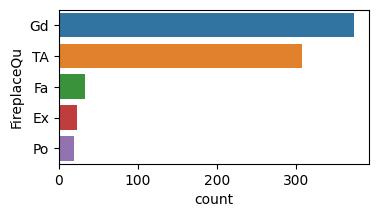

In [13]:
print(houseprice_train['FireplaceQu'].isna().sum())
#visualizing the categories of FireplaceQu
sorted_order = houseprice_train['FireplaceQu'].value_counts().index
plt.figure(figsize = (4,2))
sns.countplot(data = houseprice_train, y = 'FireplaceQu', order = sorted_order)
plt.show()

We can see that GD and TA categories are the most frequent, we will impute missing values randomly using these categories

In [14]:
# Calculating counts of TA and GD
gd_count = houseprice_train['FireplaceQu'].value_counts().get('Gd', 0)
ta_count = houseprice_train['FireplaceQu'].value_counts().get('TA', 0)
total_count = gd_count + ta_count
# Calculating proportions of TA and GD
gd_prob = gd_count / total_count
ta_prob = ta_count / total_count

def random_impute(value):
    if pd.isna(value):
        return np.random.choice(['Gd', 'TA'], p=[gd_prob, ta_prob])
    else:
        return value
# Imputing
houseprice_train['FireplaceQu'] = houseprice_train['FireplaceQu'].apply(random_impute)
houseprice_train['FireplaceQu'].isna().sum()

0

### LotFrontage

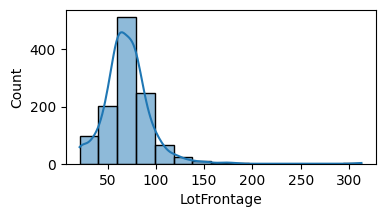

In [15]:
# Visualizing the distribution of LotFrontage
plt.figure(figsize = (4,2))
sns.histplot(data = houseprice_train, x = 'LotFrontage', bins = 15, kde = True)
plt.show()

The `LotFrontge` values appear to be normally distributed. We will therefore do our imputation using the mean.

In [16]:
houseprice_train['LotFrontage'] = houseprice_train['LotFrontage'].fillna(houseprice_train['LotFrontage'].mean())
houseprice_train['LotFrontage'].isna().sum()

0

We will try to have a look at all the remaining columns at once;

GarageFinish object
GarageType object
GarageQual object
GarageCond object
GarageYrBlt float64


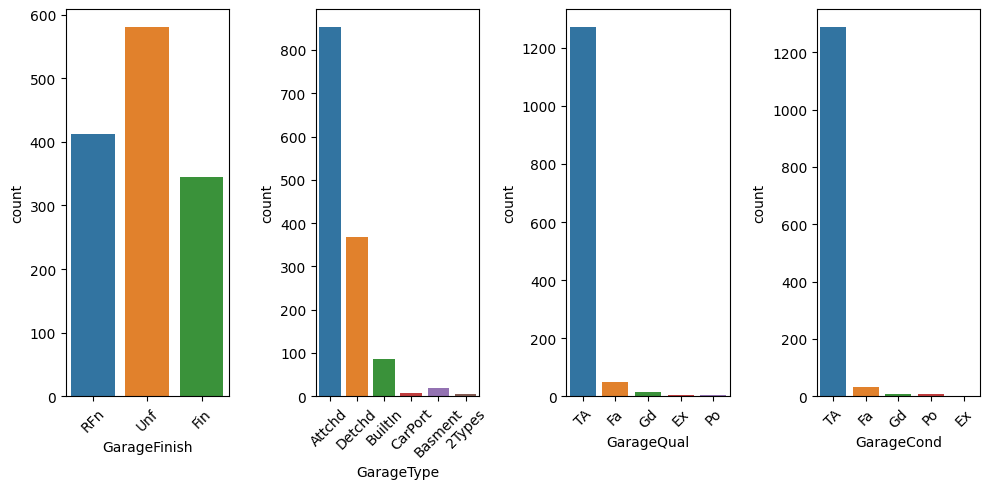

In [17]:
cols_missing = ['GarageFinish','GarageType','GarageQual','GarageCond','GarageYrBlt']
for col in cols_missing:
    print(col, houseprice_train[col].dtype)
fig, ax = plt.subplots(1,4, figsize = (10,5))
sns.countplot(data = houseprice_train, x ='GarageFinish' , ax=ax[0])
sns.countplot(data = houseprice_train, x = 'GarageType', ax = ax[1])
sns.countplot(data = houseprice_train, x = 'GarageQual', ax = ax[2])
sns.countplot(data = houseprice_train, x = 'GarageCond', ax = ax[3])
for axis in ax:
    axis.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


We will impute `GarageFinish` missing values randomly. As for the other three variables, we will impute them using the mode.

In [18]:
RFn_count = houseprice_train['GarageFinish'].value_counts().get('RFn',0)
Unf_count = houseprice_train['GarageFinish'].value_counts().get('Unf',0)
Fin_count = houseprice_train['GarageFinish'].value_counts().get('Fin',0)
RFn_prop = RFn_count/np.sum(np.array((RFn_count, Unf_count, Fin_count)))
Unf_prop = Unf_count/np.sum(np.array((RFn_count, Unf_count, Fin_count)))
Fin_prop = Fin_count/np.sum(np.array((RFn_count, Unf_count, Fin_count)))

def random_imputer(value):
    if pd.isna(value):
        return np.random.choice(['RFn','Unf','Fin'], p = [RFn_prop, Unf_prop, Fin_prop])
    else:
        return value
houseprice_train['GarageFinish'] = houseprice_train['GarageFinish'].apply(random_imputer)
houseprice_train['GarageType'] = houseprice_train['GarageType'].fillna(houseprice_train['GarageType'].mode()[0])
houseprice_train['GarageQual'] = houseprice_train['GarageQual'].fillna(houseprice_train['GarageQual'].mode()[0])
houseprice_train['GarageCond'] = houseprice_train['GarageCond'].fillna(houseprice_train['GarageCond'].mode()[0])


How many observations have the year of building garage equal to the year of construction?

In [19]:
np.sum(houseprice_train['GarageYrBlt'] == houseprice_train['YearBuilt'])

1060

From the above, we can see that majority of the garages were built on the same year that the houses were built. We will therefore impute missing values in `GarageYrBlt` with corresponding values in `YearBuilt`.

houseprice_train['GarageYrBlt'] = pd.to_datetime(houseprice_train['GarageYrBlt'], errors='coerce')
houseprice_train['YearBuilt'] = pd.to_datetime(houseprice_train['YearBuilt'], errors='coerce')
houseprice_train['YearRemodAdd'] = pd.to_datetime(houseprice_train['YearRemodAdd'], errors='coerce')
houseprice_train['YrSold'] = pd.to_datetime(houseprice_train['YrSold'], errors='coerce')

In [20]:
houseprice_train['GarageYrBlt'] = np.where(houseprice_train['GarageYrBlt'].isna(),houseprice_train['YearBuilt'],
                                           houseprice_train['GarageYrBlt'])

## Univariate data analysis
### Numerical columns



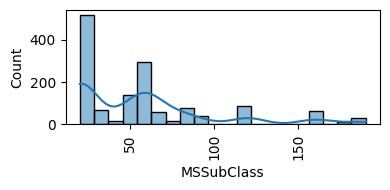

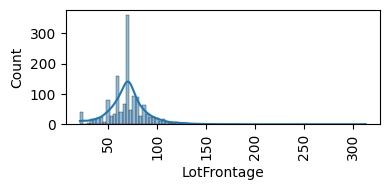

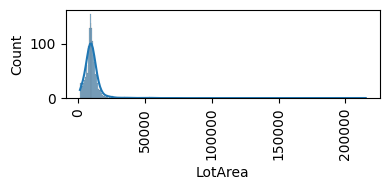

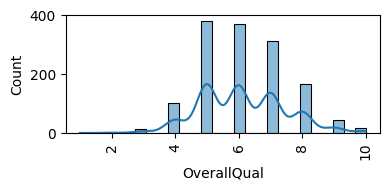

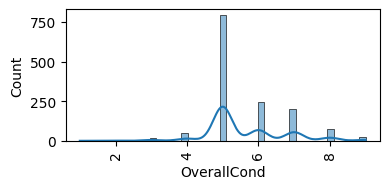

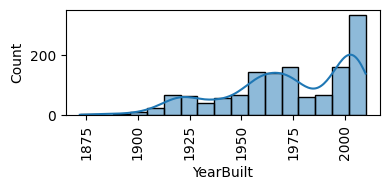

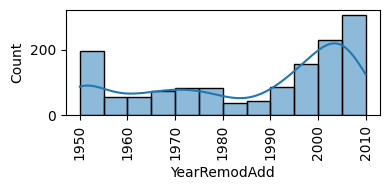

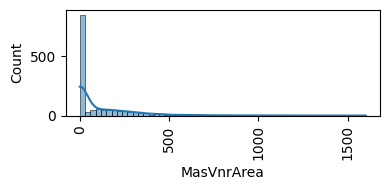

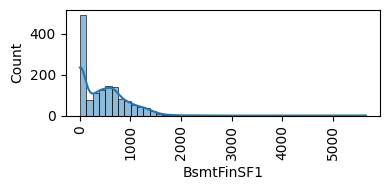

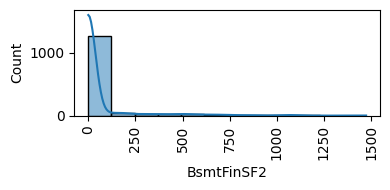

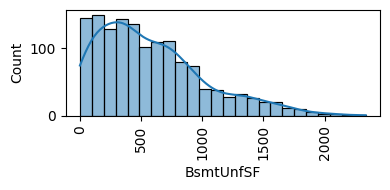

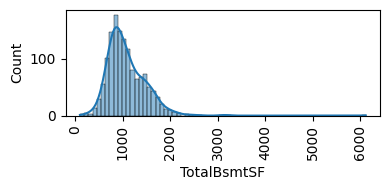

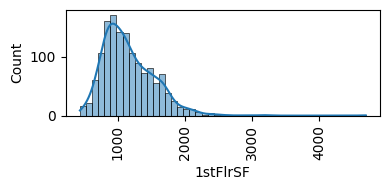

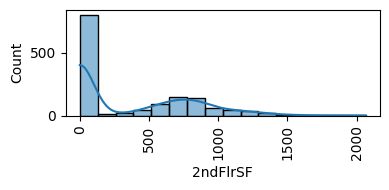

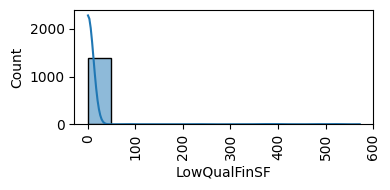

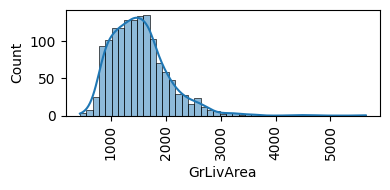

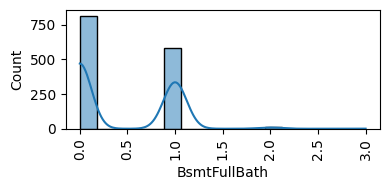

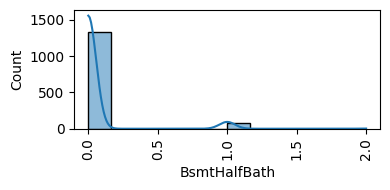

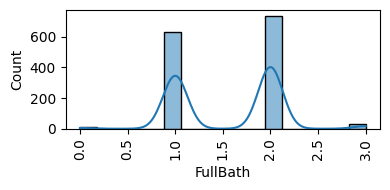

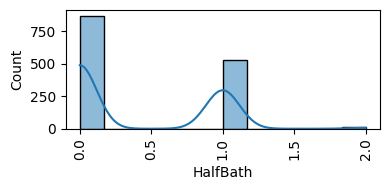

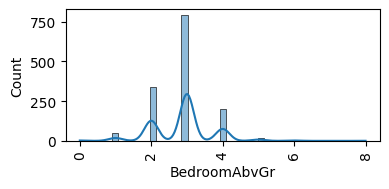

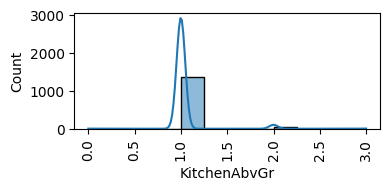

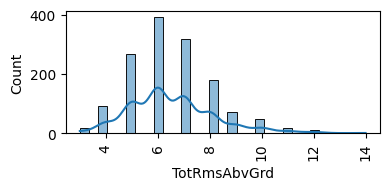

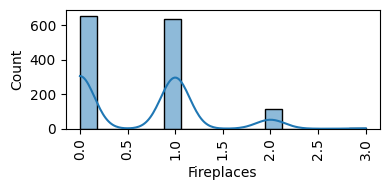

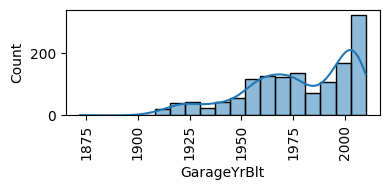

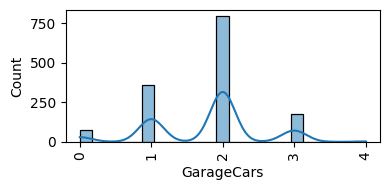

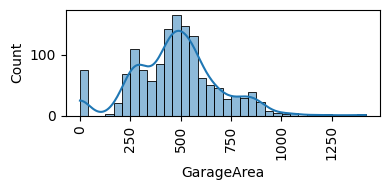

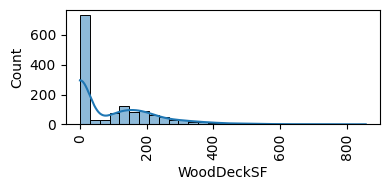

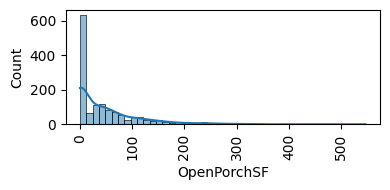

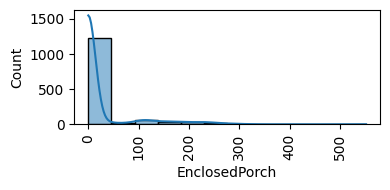

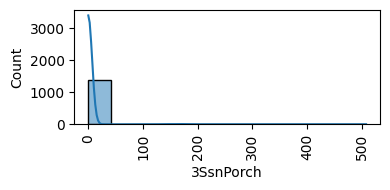

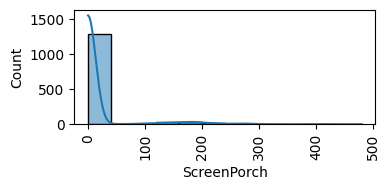

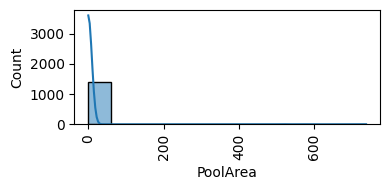

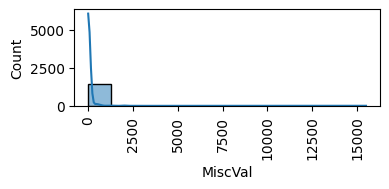

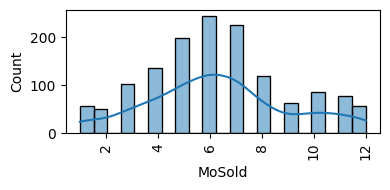

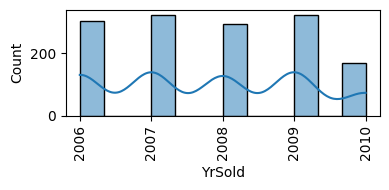

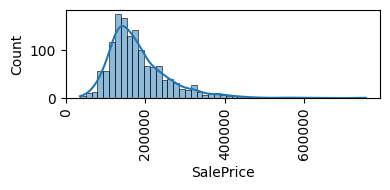

In [21]:
num_cols = [col for col in houseprice_train if (houseprice_train[col].dtype) in (['int64','float64'])]
for col in num_cols:
    plt.figure(figsize = (4,2))
    sns.histplot(data = houseprice_train, x = col, kde = True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    

We can see that a lot of numerical columns have outliers. We will therefore fit two models where in one, all numerical columns have been scaled and in the other, the values are as they are.
Next we will do bivariate analysis on numerical columns. We will make use of the correlation matrix to achieve this;

In [22]:
houseprice_train[num_cols].corr().style.background_gradient(cmap='viridis')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.360029,-0.138298,0.038952,-0.063240,0.032256,0.043906,0.023024,-0.067783,-0.064875,-0.139572,-0.253332,-0.254277,0.306522,0.047349,0.073167,0.007005,-0.002111,0.121525,0.181273,-0.031432,0.266075,0.030657,-0.040128,0.046532,-0.034897,-0.094523,-0.014568,-0.005684,-0.016768,-0.041226,-0.026202,0.008496,-0.022705,-0.016463,-0.026526,-0.082281
LotFrontage,-0.360029,1.000000,0.305456,0.232301,-0.054593,0.114997,0.078787,0.179346,0.215607,0.041441,0.116181,0.384890,0.416577,0.073493,0.036597,0.369141,0.089305,-0.007221,0.182098,0.046638,0.240061,0.002967,0.323633,0.235394,0.085113,0.269585,0.324962,0.075480,0.134440,0.011653,0.065067,0.037013,0.181565,0.000992,0.005470,0.006502,0.333483
LotArea,-0.138298,0.305456,1.000000,0.104763,-0.002941,0.014163,0.010765,0.104010,0.213450,0.111381,-0.008757,0.275637,0.296342,0.052246,0.004237,0.260524,0.157024,0.047774,0.124752,0.013808,0.119153,-0.016379,0.189107,0.268960,0.001735,0.153812,0.180207,0.172281,0.083860,-0.022978,0.021153,0.042818,0.077814,0.041567,0.001070,-0.012886,0.264803
OverallQual,0.038952,0.232301,0.104763,1.000000,-0.121155,0.570266,0.540129,0.409656,0.211652,-0.072897,0.278239,0.509473,0.486418,0.291858,-0.034460,0.594985,0.082932,-0.048771,0.576543,0.256616,0.096722,-0.145423,0.438254,0.392978,0.551794,0.607663,0.561612,0.230274,0.297678,-0.122678,0.032014,0.059290,0.065474,-0.025344,0.064301,-0.024251,0.786765
OverallCond,-0.063240,-0.054593,-0.002941,-0.121155,1.000000,-0.389624,0.057361,-0.134961,-0.057034,0.036885,-0.159769,-0.221992,-0.145056,0.022496,0.023482,-0.085187,-0.064559,0.115694,-0.190209,-0.072977,0.016070,-0.062543,-0.058852,-0.030047,-0.309299,-0.193904,-0.163341,-0.013206,-0.041823,0.075663,0.022557,0.050897,-0.003298,0.070685,-0.008530,0.048668,-0.093567
YearBuilt,0.032256,0.114997,0.014163,0.570266,-0.389624,1.000000,0.593163,0.311745,0.242714,-0.053568,0.136097,0.398561,0.283967,0.001651,-0.186011,0.191592,0.179642,-0.039926,0.474767,0.233529,-0.080611,-0.176661,0.091792,0.143433,0.843956,0.536963,0.475678,0.225469,0.185426,-0.391886,0.033540,-0.052448,0.004636,-0.028282,0.008403,-0.014693,0.518736
YearRemodAdd,0.043906,0.078787,0.010765,0.540129,0.057361,0.593163,1.000000,0.172112,0.110541,-0.076383,0.159275,0.265707,0.244458,0.131614,-0.064714,0.282058,0.103877,-0.016574,0.454840,0.168525,-0.050080,-0.124331,0.189216,0.100277,0.604545,0.423161,0.369665,0.199144,0.218889,-0.203322,0.040746,-0.044172,0.004870,-0.000748,0.015944,0.029968,0.500266
MasVnrArea,0.023024,0.179346,0.104010,0.409656,-0.134961,0.311745,0.172112,1.000000,0.259291,-0.077978,0.103094,0.371677,0.348471,0.170468,-0.070279,0.389884,0.077607,0.024618,0.277278,0.197999,0.101925,-0.024685,0.283266,0.241914,0.267295,0.363992,0.370982,0.157566,0.124018,-0.116271,0.018240,0.059422,0.011161,-0.027143,-0.009909,-0.005249,0.474525
BsmtFinSF1,-0.067783,0.215607,0.213450,0.211652,-0.057034,0.242714,0.110541,0.259291,1.000000,-0.060807,-0.551475,0.504307,0.449253,-0.146842,-0.067677,0.200188,0.639301,0.063313,0.060432,-0.015215,-0.110303,-0.047761,0.043425,0.250394,0.173992,0.215661,0.288913,0.196236,0.098352,-0.109122,0.028958,0.057169,0.141557,0.009120,-0.020850,0.020268,0.368849
BsmtFinSF2,-0.064875,0.041441,0.111381,-0.072897,0.036885,-0.053568,-0.076383,-0.077978,-0.060807,1.000000,-0.229907,0.086766,0.096786,-0.102037,0.014164,-0.012671,0.153697,0.069425,-0.077119,-0.035756,-0.016933,-0.030390,-0.037115,0.042980,-0.067773,-0.045063,-0.025604,0.065614,0.002020,0.037693,-0.030142,0.087231,0.041342,0.006542,-0.018511,0.031912,-0.020196


## Data Preprocessing
### Checking categorical variables

How many unique categories are there in each categorical variable?


In [23]:
unique_counts = {col: houseprice_train[col].nunique() for col in houseprice_train if houseprice_train[col].dtype == 'object'}

# Convert the dictionary to a DataFrame
unique_counts_df = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['unique_values']).reset_index()

# Rename columns for clarity
unique_counts_df = unique_counts_df.rename(columns={'index': 'column_name'})

display(unique_counts_df)
cat_columns = [col for col in houseprice_train.columns if houseprice_train[col].dtype == 'object']
print(cat_columns)

,column_name,unique_values
0,MSZoning,5
1,Street,2
2,LotShape,4
3,LandContour,4
4,Utilities,2
5,LotConfig,5
6,LandSlope,3
7,Neighborhood,25
8,Condition1,9
9,Condition2,8


['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


There are some categorical variables with many unique values. It is clear however that most of our categorical variables have less than 10 unique values.
Next we will do one hot encoding of all these columns.

In [24]:
houseprice_train_cat = houseprice_train[cat_columns]
houseprice_train_cat = pd.get_dummies(houseprice_train_cat, drop_first = True)
houseprice_train_cat.shape

(1412, 193)

In [25]:
houseprice_train_num = houseprice_train[num_cols]
houseprice_train_num.shape
houseprice_train_df = pd.concat([houseprice_train_num, houseprice_train_cat], axis = 1)
print(houseprice_train_df.shape)
# For later use in ColumnTransformer alongside num_cols
cat_cols = [col for col in houseprice_train_df if col not in num_cols]
print(len(cat_cols))
print(len(num_cols))

(1412, 230)
193
37


# Model fitting

### Linear regression

We will use a linear regrssion model as our baseline model.

In [26]:
X = houseprice_train_df.drop(columns = ['SalePrice'], axis = 1)
y = houseprice_train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [27]:
base_score = linreg.score(X_test, y_test)
base_mean_sq_error = mean_squared_error(y_test, y_pred)
print(f'R squared value is: {base_score}')
print(f'The root mean squared error is: {np.sqrt(base_mean_sq_error)}')
print(f'The standard deviation of the target variable is: {y_test.std()}')

R squared value is: 0.75111344786692
The root mean squared error is: 41675.09199590083
The standard deviation of the target variable is: 83635.10300121593


From the above, we can see that the root mean squared error is much less than the standard deviation of the target variable. This is a positive indication that our model is capturing some of the signal in the data and not just the noise. We will however verify this by using cross validation.

## Cross validation

In [28]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
r_scores = cross_val_score(linreg,X_train,y_train, cv = kfold)
rmse = cross_val_score(linreg, X_train, y_train, cv = kfold,
                      scoring = 'neg_mean_squared_error')
print(f'R squared scores are: {r_scores} and their mean is: {r_scores.mean()}')
print(f'Root mean squared errors are: {np.sqrt(-rmse)} and their mean is: {np.sqrt(-rmse).mean()}')

R squared scores are: [0.86037826 0.89007829 0.70283732 0.77199869 0.89124183] and their mean is: 0.8233068772049229
Root mean squared errors are: [26203.90602308 23404.0481015  38513.22924327 42705.63798956
 26906.56802026] and their mean is: 31546.67787553378


From the above, we can see that the $R^2$-scores of our model vary from 0.7 to 0.89. The values for the root mean squared errors also appear to vary widely from 23099 to 43570. This means that our model is overfitting on some subsets and thus more data preprocessing and hyperparameter tuning is required.

Our first data preprocessing step will be doing log transformation of the target variable after ascertaining that the the values of the target variable have a wide range.

In [29]:
print(y.max() - y.min())

720100


There is a difference of over $700,000 between the cheapest and the most expensive house! Log transformation of the target variable is definitely warranted.

## Log transformation of house prices


In [30]:
# Log transformation of target variable in training set
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
#Repeating cross validation with transformed target variable
r_scores = cross_val_score(linreg,X_train,y_train_log, cv = kfold)
rmse = cross_val_score(linreg, X_train, y_train_log, cv = kfold,
                      scoring = 'neg_mean_squared_error')
print(f'R squared scores are: {r_scores} and their mean is: {r_scores.mean()}')
print(f'Root mean squared errors are: {np.sqrt(-rmse)} and their mean is: {np.sqrt(-rmse).mean()}')


R squared scores are: [0.86282907 0.90407971 0.7934806  0.82629776 0.91181542] and their mean is: 0.8597005151596322
Root mean squared errors are: [0.13092487 0.11665783 0.17186267 0.16330444 0.12387341] and their mean is: 0.1413246422333942


From the above, we can see that a log transformation reduces the range of our $R^2$ scores and the root mean squared error is also relatively low. Next, we will evaluate the performance of the model based on the log transformed test set.

In [31]:
linreg_log = LinearRegression()
linreg_log.fit(X_train, y_train_log)
r_score = linreg_log.score(X_test, y_test_log)
y_pred_log = linreg_log.predict(X_test)
mse = mean_squared_error(y_test_log,y_pred_log)
print(f'The R squared score is: {r_score}')
print(f"The root mean squared error is: {np.sqrt(mse)}")
print(f"The standard deviation of our test target variable is {y_test_log.std()}")

The R squared score is: 0.7854890188984344
The root mean squared error is: 0.19014372982564973
The standard deviation of our test target variable is 0.4110266568987633


Compared to the initial value before log transformation, we can see that our $R^2$ values improves from 0.75 to 0.79. This clearly shows that there is an improvement brought about by log transformation of house prices. Based on this improvement, all other models going forward will be evaluated based on the tranformed target variable.

## Scaling of numerical features

We will use `StandardScaler` to transform numerical columns and leave categorical c

In [32]:
num_cols.remove('SalePrice')

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # Scale continuous features
        ('cat', 'passthrough', cat_cols)  # Keep one-hot encoded features as they are
    ])
steps = [('transformer',preprocessor),
        ('linear regression', LinearRegression())]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train_log)
print(pipeline.score(X_test,y_test_log))
ypred = np.exp(pipeline.predict(X_test))
print(ypred[:5])
print(y_test[:5])


-4.725807088195142e+17
[256965.95762504 118331.39191722 458335.4055509   89739.21086648
 158395.2692724 ]
Id
765    270000
891    122900
350    437154
199    104000
210    145000
Name: SalePrice, dtype: int64


Scaling does not seem to be working as expected

## Regularization

Next, we will regularize our model coefficients using ridge and lasso regression.

### Ridge regression

In [34]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
param_grid = {'alpha': np.linspace(0.1, 20, 10),
             'solver': ['sparse_cg', 'lsqr', 'cholesky', 'saga', 'svd', 'sag', 'auto', 'lbfgs']}
ridge = Ridge()
ridge_cv = RandomizedSearchCV(ridge, param_grid, cv = kf)
ridge_cv.fit(X_train, y_train_log)
print(ridge_cv.best_params_, ridge_cv.best_score_)

{'solver': 'svd', 'alpha': 2.311111111111111} 0.8822544259124611


We will now fit a ridge regression model with the specified hyper parameters.

In [35]:
ridge_reg = Ridge(alpha = 2.311111111111111, solver = 'auto')
ridge_reg.fit(X_train, y_train_log)
ridge_score = ridge_reg.score(X_test, y_test_log)
y_r_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test_log, y_r_pred)
print(f'The R - Squared value on the test set is: {ridge_score}')
print(f'The root mean squared error for the ridge model is: {np.sqrt(ridge_mse)}')


The R - Squared value on the test set is: 0.816002723210929
The root mean squared error for the ridge model is: 0.17610145400408028


Our ridge regression model performs better than our regression model on the test set across the two metrics under consideration: root mean squared error and $R^2$

### Lasso regression

In [36]:
param_grid = {'alpha': np.linspace(0.0001, 0.001, 100),
             'selection' : ['random', 'cyclic']}
lasso = Lasso()
lasso_cv = RandomizedSearchCV(lasso, param_grid, cv = kf)
lasso_cv.fit(X_train, y_train_log)
print(lasso_cv.best_params_, lasso_cv.best_score_)

{'selection': 'random', 'alpha': 0.0002090909090909091} 0.8766152984157947


Lasso regression seems to have a slightly better performance than Ridge regression as long as the best score is concerned. Next, we will see how lasso regression performs on the test set.

In [37]:
lasso_reg = Lasso(alpha = 0.0002909090909090909, selection = 'cyclic')
lasso_reg.fit(X_train, y_train_log)
lasso_score = lasso_reg.score(X_test, y_test_log)
y_l_pred = lasso_reg.predict(X_test)
lasso_mse = mean_squared_error(y_test_log, y_l_pred)
print(f'The R - Squared value on the test set is: {lasso_score}')
print(f'The root mean squared error for the Lasso model is: {np.sqrt(lasso_mse)}')


The R - Squared value on the test set is: 0.8081026333731357
The root mean squared error for the Lasso model is: 0.17984226004223022


Despite performing well than ridge regression at the cross validation stage, lasso regression seems to generalize slightly poorly to the test test compared to ridge regression.

## Feature Engineering
### Using lasso regression

We will select the top 100 important features using lasso regression.

In [38]:
lasso_selection = SelectFromModel(lasso_reg, prefit=True,max_features=100)
selected_features = X_train.columns[lasso_selection.get_support()]
X_train_selected = lasso_selection.transform(X_train)
X_test_selected = lasso_selection.transform(X_test)


## Fitting ridge regression on the selected features
Next, we will fit ridge regression model since it performed best before feature engineering. This will enable us understand the effect of feature engineering without much coding.

In [39]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
param_grid = {'alpha': np.linspace(1, 20, 50),
             'solver': ['sparse_cg', 'lsqr', 'cholesky', 'saga', 'svd', 'sag', 'auto', 'lbfgs']}
ridge_fet_eng = Ridge()
ridge_fet_eng_cv = RandomizedSearchCV(ridge_fet_eng, param_grid, cv = kf)
ridge_fet_eng_cv.fit(X_train_selected, y_train_log)
print(ridge_fet_eng_cv.best_params_, ridge_fet_eng_cv.best_score_)

{'solver': 'cholesky', 'alpha': 1.3877551020408163} 0.8807392383376286


In [40]:
ridge_reg_fet = Ridge(alpha = 4.1020408163265305, solver = 'svd')
ridge_reg_fet.fit(X_train_selected, y_train_log)
ridge_reg_fet_score = ridge_reg_fet.score(X_test_selected, y_test_log)
y_r_fet_pred = ridge_reg_fet.predict(X_test_selected)
ridge_mse = mean_squared_error(y_test_log, y_r_fet_pred)
print(f'The R - Squared value on the test set is: {ridge_reg_fet_score}')
print(f'The root mean squared error for the ridge model is: {np.sqrt(ridge_mse)}')


The R - Squared value on the test set is: 0.8452652419448169
The root mean squared error for the ridge model is: 0.16149206362363816


From the above, we can see that the $R^2$ score of our ridge regression model improves from 0.82 to 0.845 and there is a reduction in the value of the root mean squared error.

Due to this improvement, going forward, we will use the selected features to fit the other models.

## Random Forest

### Cross validation and optimization

In [41]:
param_grid = { 'min_samples_split': [1,2,3,4,5,6,7],
             'min_samples_leaf': [1,2,3,4,5,6,7]}
rf = RandomForestRegressor()
rf_cv = RandomizedSearchCV(rf, param_grid, cv = kf)
rf_cv.fit(X_train, y_train_log)
print(rf_cv.best_score_, rf_cv.best_params_)

0.8569214090238668 {'min_samples_split': 3, 'min_samples_leaf': 1}


In [42]:
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train_log)
rf_score = rf_model.score(X_test, y_test_log)
rf_y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test_log, rf_y_pred)
print(f'The R - Squared value on the test set is: {rf_score}')
print(f'The root mean squared error for the Random Forest model is: {np.sqrt(rf_mse)}')

The R - Squared value on the test set is: 0.8433500572905476
The root mean squared error for the Random Forest model is: 0.16248840075956703


Next, we will select the most important features based on their feature importances and fit another model based on those.

In [43]:
features = X_train.columns
importances = rf_model.feature_importances_
# Create a dataframe showing features alongside their feature importances
fi_df = pd.DataFrame({'column_names':features, 'importances':importances})
fi_df = fi_df.sort_values('importances',ascending = False)
# Extract columns whose contribution is more than 1% in the prediction of house price
rf_selected_features = list(fi_df[fi_df['importances'] >= 0.01].column_names)
print(len(rf_selected_features))
# Create a new training set and testing set based on the selected features
X_train_rf = X_train[rf_selected_features]
X_test_rf = X_test[rf_selected_features]

11


In [44]:
rf_sf_model = RandomForestRegressor(random_state = 42)
rf_sf_model.fit(X_train_rf, y_train_log)
rf_sf_score = rf_sf_model.score(X_test_rf, y_test_log)
rf_sf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test_log, rf_sf_pred)
print(f'The R - Squared value on the test set is: {rf_sf_score}')
print(f'The root mean squared error for the Random Forest model is: {np.sqrt(rf_mse)}')


The R - Squared value on the test set is: 0.8442764952882365
The root mean squared error for the Random Forest model is: 0.16248840075956703


Due to feature selection, there is a very slight improvement in the performance of our model if we only consider the change in $R^2$ and root mean squared error.
However, this is a great improvement when you consider that we come down to using 11 features only. We save a lot on computational power.

In [45]:
# Create a dataframe of column names and feature importance of newly fit model
fi_df = pd.DataFrame({'column_names':X_train_rf.columns, 'importances':rf_sf_model.feature_importances_})
fi_df = fi_df.sort_values('importances',ascending = False)
display(fi_df)

,column_names,importances
0,OverallQual,0.505207
1,GrLivArea,0.153850
2,TotalBsmtSF,0.059983
3,GarageArea,0.055993
6,YearBuilt,0.047292
4,1stFlrSF,0.040928
7,BsmtFinSF1,0.040189
9,LotArea,0.029402
5,GarageCars,0.029235
10,OverallCond,0.020325


## Feature importance plot

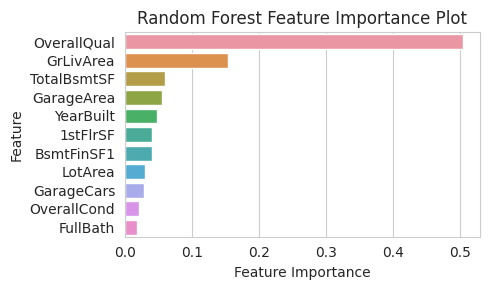

In [46]:
sns.set_style("whitegrid")
plt.figure(figsize = (5,3))
sns.barplot(data = fi_df, y = "column_names", x = "importances")
plt.ylabel("Feature")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance Plot")
plt.tight_layout()
plt.show()

From the above plot, we can see that the  top 5 most important features in determining the price of a house are overall material and finish quality (`OverallQual`), above grade living area in square feet (`GrLivArea`), total area of basement in square feet (`TotalBsmtSF`), size of garage in square feet (`GarageArea`) and lastly the year of original construction (`YearBuilt`).

We will now fit our last model; Extreme gradient boosting (XGBoost)

## Extreme Gradient Boosting

In [47]:
xgb_model = xgb.XGBRegressor(random_state = 100) 
xgb_model.fit(X_train, y_train_log)
xgb_score = xgb_model.score(X_test, y_test_log)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test_log, xgb_pred)
print(f'The R - Squared value on the test set is: {xgb_score}')
print(f'The root mean squared error for the XGBoost model is: {np.sqrt(xgb_mse)}')

The R - Squared value on the test set is: 0.8506326211362423
The root mean squared error for the XGBoost model is: 0.15866645698767476


Extreme gradient boosting attains superior performance than all other models. Next we will perform cross validation and hyperparameter tuning to see how better it can get.

### Cross validation and hyperparameter tuning

In [48]:
param_grid = {
    'n_estimators': [200],                 # Start with a smaller number of trees
    'max_depth': [1, 2],                        # Shallow trees to prevent overfitting
    'learning_rate': [ 0.09,0.08],                # Start with a moderate learning rate
    'subsample': [0.5, 0.4],                    # Fraction of samples used for training
    'colsample_bytree': [0.8],             # Fraction of features used for each tree
    'gamma': [0]                           # Regularization term
}              

xgb_tuned_model = xgb.XGBRegressor(tree_method='gpu_hist',objective='reg:squarederror', random_state=42)
xgb_cv = GridSearchCV(xgb_tuned_model, param_grid, cv = kf)
xgb_cv.fit(X_train, y_train_log)
print(xgb_cv.best_score_, xgb_cv.best_params_)

0.8950177019639799 {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.09, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.5}


In [49]:
xgb_final_model = xgb.XGBRegressor(tree_method = 'gpu_hist',objective = "reg:squarederror",
                                  colsample_bytree = 0.8, gamma = 0, learning_rate = 0.09,
                                  max_depth = 2, n_estimators = 200, subsample = 0.5,
                                  random_state = 42)
xgb_final_model.fit(X_train, y_train_log)
xgb_final_score = xgb_final_model.score(X_test, y_test_log)
xgb_final_pred = xgb_final_model.predict(X_test)
xgb_final_mse = mean_squared_error(y_test_log, xgb_final_pred)
print(f'The R - Squared value on the test set is: {xgb_final_score}')
print(f'The root mean squared error for the final XGBoost model is: {np.sqrt(xgb_final_mse)}')

The R - Squared value on the test set is: 0.8861859301723208
The root mean squared error for the final XGBoost model is: 0.13850173722534867


The Extreme gradient boosting model performs exceptionally well across both metrics, ie $R^2$ and mean squared error.

### Feature importances

In [50]:
xgb_importances = xgb_final_model.feature_importances_
features = X_train.columns
xgb_fi_df = pd.DataFrame({"column_name":features,
                         "feature_importance": xgb_importances})
xgb_fi_df = xgb_fi_df.sort_values("feature_importance", ascending = False)

## Feature engineering

We shall fit another XGBoost model using features that contribute to more than 1% in prediction of house prices

In [51]:
selected_features = (xgb_fi_df[xgb_fi_df["feature_importance"]>=0]).column_name
new_X_train_df = X_train[list(selected_features)]
new_X_test_df = X_test[list(selected_features)]


In [52]:
param_grid = {
    'n_estimators': [450],                 # Start with a smaller number of trees
    'max_depth': [2],                        # Shallow trees to prevent overfitting
    'learning_rate': [ 0.07,0.6],                # Start with a moderate learning rate
    'subsample': [0.2,0.3],                    # Fraction of samples used for training
    'colsample_bytree': [0.6,0.7],             # Fraction of features used for each tree
    'gamma': [0]                           # Regularization term
}              

xgb_fe_model = xgb.XGBRegressor(tree_method='gpu_hist',objective='reg:squarederror', random_state=42)
xgb_fe_cv = GridSearchCV(xgb_fe_model, param_grid, cv = kf)
xgb_fe_cv.fit(new_X_train_df, y_train_log)
print(xgb_fe_cv.best_score_, xgb_fe_cv.best_params_)

0.8952742325730736 {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 450, 'subsample': 0.3}


### Extreme gradient boosting model after feature engineering

In [53]:
xgb_afi = xgb.XGBRegressor(tree_method = 'gpu_hist', objective = 'reg:squarederror',
                          random_state = 42, colsample_bytree = 0.6, gamma = 0, 
                          learning_rate = 0.07, max_depth = 2, n_estimators = 450, 
                          subsample = 0.3)
xgb_afi.fit(new_X_train_df, y_train_log)
xgb_afi_score = xgb_afi.score(new_X_test_df, y_test_log)
xgb_afi_pred = xgb_afi.predict(new_X_test_df)
xgb_afi_mse = mean_squared_error(y_test_log, xgb_afi_pred)
print(f'The R - Squared value on the test set is: {xgb_afi_score}')
print(f'The root mean squared error for the final XGBoost model is: {np.sqrt(xgb_afi_mse)}')


The R - Squared value on the test set is: 0.8836833269547093
The root mean squared error for the final XGBoost model is: 0.14001618166623264


Due to randomness introduced during model training, there is slight variation in how the model performs with respect to the two metrics being considered. However, the performance of the two extreme gradient boosting models is consistently around the same level across multiple runs.

This can also be considered a great improvement if we are to consider the amount of computational power saved as a result of reduced number of features during the fitting of the model.

## Feature importance plot of top 15 features

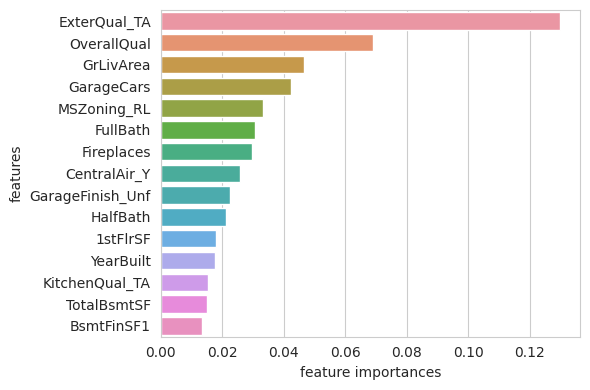

In [54]:
features = new_X_train_df.columns
feature_importances = xgb_afi.feature_importances_
fi_afi_df = pd.DataFrame({"features":features, "feature_importances":feature_importances})
fi_afi_df = fi_afi_df.sort_values('feature_importances', ascending = False)
fi_afi_df = fi_afi_df[:15]
sns.set_style('whitegrid')
plt.figure(figsize = (6,4))
sns.barplot(data = fi_afi_df, y = 'features', x = 'feature_importances')
plt.xlabel("feature importances")
plt.tight_layout()
plt.show()

# Conclusion

The most important features in determining house prices, according to the Extreme Gradient Boosting (XGBoost) model, are as follows:

* **Exterior Material Quality** (`ExterQual_TA`): Whether the exterior material quality is good,
* **Overall Material and Finish Quality** (`OverallQual`): The overall quality of materials and finish,
* **Above Grade Living Area** (`GrLivArea`): Living area above grade (in square feet),
* **Number of Fireplaces** (`Fireplaces`): The number of fireplaces, and
* **Garage Size** (`GarageCars`): Garage size in terms of car capacity.
* **Full Bathrooms above grade** (`FullBath`): Number of full bathrooms above grade.
  

  
The XGBoost model outperforms all other models, making it the recommended choice for predicting house prices. XGBoost achieves exceptional performance by combining the benefits of gradient descent, which accelerates convergence, with ensembling techniques, which reduce variance. In other words, it leverages the strengths of both traditional linear regression (for rapid learning) and ensemble methods (for stability and improved accuracy).